In [1]:
import pandas as pd
import os
import requests

%run "../util/funcionesEurostat.ipynb"

In [2]:
def get_population():
  url = "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/lfsq_pganws/?format=SDMX-CSV&compressed=true"

  response = requests.get(url)

  with open('estat_lfsq_pganws_en.csv', 'wb') as f:
      f.write(response.content)

  return {"message": "CSV downloaded"}

In [3]:
print(get_population())

{'message': 'CSV downloaded'}


In [4]:
import gzip

archivo_comprimido = 'estat_lfsq_pganws_en.csv' 
nombre_descomprimido = 'estat_lfsq_pganws-decodificado.csv'  # Cambia 'nombre_del_archivo.tsv' al nombre deseado para el archivo descomprimido

with gzip.open(archivo_comprimido, 'rb') as f:
    datos_descomprimidos = f.read()

# Guardar los datos descomprimidos en un archivo
with open(nombre_descomprimido, 'wb') as f:
    f.write(datos_descomprimidos)

print("Archivo descomprimido exitosamente.")

Archivo descomprimido exitosamente.


In [5]:
df = pd.read_csv("estat_lfsq_pganws-decodificado.csv")

if not os.path.exists("../data/raw"):
        os.makedirs("../data/raw")
df.to_csv("../data/raw/eurostat.csv")


In [6]:
df.head()

,DATAFLOW,LAST UPDATE,freq,unit,sex,citizen,age,wstatus,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:LFSQ_PGANWS(1.0),15/03/24 11:00:00,Q,THS_PER,F,EU27_2020_FOR,Y15-19,ACT,AT,1998-Q1,NaN,u
1,ESTAT:LFSQ_PGANWS(1.0),15/03/24 11:00:00,Q,THS_PER,F,EU27_2020_FOR,Y15-19,ACT,AT,1999-Q1,NaN,u
2,ESTAT:LFSQ_PGANWS(1.0),15/03/24 11:00:00,Q,THS_PER,F,EU27_2020_FOR,Y15-19,ACT,AT,2000-Q1,NaN,u
3,ESTAT:LFSQ_PGANWS(1.0),15/03/24 11:00:00,Q,THS_PER,F,EU27_2020_FOR,Y15-19,ACT,AT,2000-Q2,NaN,u
4,ESTAT:LFSQ_PGANWS(1.0),15/03/24 11:00:00,Q,THS_PER,F,EU27_2020_FOR,Y15-19,ACT,AT,2001-Q1,NaN,u


eliminamos columnas inutiles

In [7]:
df = df.drop(['DATAFLOW','freq','unit','OBS_FLAG','LAST UPDATE'],axis=1)

cambiar Nan por ceros en OBS_VALUE

In [8]:
df['OBS_VALUE'] = df['OBS_VALUE'].fillna(0)
df['OBS_VALUE'] = df['OBS_VALUE'].round(1)


añdimos columnas con fechas año mes y dia

In [9]:
# Función para mapear los trimestres a meses específicos
def map_quarter_to_month(quarter):
    year, q = quarter.split('-Q')
    if q == '1':
        return f"{year}-03-01"
    elif q == '2':
        return f"{year}-06-01"
    elif q == '3':
        return f"{year}-09-01"
    elif q == '4':
        return f"{year}-12-01"
    else:
        return None

# Crear la nueva columna 'year_month' basada en la columna 'TIME_PERIOD'
df['year_month'] = df['TIME_PERIOD'].apply(map_quarter_to_month)

nos quedamos con los extranjeros activos

In [10]:
df_foreigners_act = df[(df['citizen']=='FOR') & (df['wstatus']=='ACT')]
df_foreigners_act.head(10)

,sex,citizen,age,wstatus,geo,TIME_PERIOD,OBS_VALUE,year_month
378374,F,FOR,Y15-19,ACT,AT,1998-Q1,9.5,1998-03-01
378375,F,FOR,Y15-19,ACT,AT,1999-Q1,7.3,1999-03-01
378376,F,FOR,Y15-19,ACT,AT,2000-Q1,9.7,2000-03-01
378377,F,FOR,Y15-19,ACT,AT,2000-Q2,8.8,2000-06-01
378378,F,FOR,Y15-19,ACT,AT,2001-Q1,7.7,2001-03-01
378379,F,FOR,Y15-19,ACT,AT,2002-Q1,7.6,2002-03-01
378380,F,FOR,Y15-19,ACT,AT,2003-Q1,6.5,2003-03-01
378381,F,FOR,Y15-19,ACT,AT,2003-Q2,4.6,2003-06-01
378382,F,FOR,Y15-19,ACT,AT,2003-Q3,5.6,2003-09-01
378383,F,FOR,Y15-19,ACT,AT,2003-Q4,6.2,2003-12-01


y con la fecha >= 2014

In [11]:
df_foreigners_act = df_foreigners_act[df_foreigners_act['year_month'] >= '2014-01-01']

In [12]:
df_foreigners_act.head(10)

,sex,citizen,age,wstatus,geo,TIME_PERIOD,OBS_VALUE,year_month
378424,F,FOR,Y15-19,ACT,AT,2014-Q1,7.4,2014-03-01
378425,F,FOR,Y15-19,ACT,AT,2014-Q2,6.5,2014-06-01
378426,F,FOR,Y15-19,ACT,AT,2014-Q3,6.1,2014-09-01
378427,F,FOR,Y15-19,ACT,AT,2014-Q4,7.2,2014-12-01
378428,F,FOR,Y15-19,ACT,AT,2015-Q1,5.3,2015-03-01
378429,F,FOR,Y15-19,ACT,AT,2015-Q2,5.4,2015-06-01
378430,F,FOR,Y15-19,ACT,AT,2015-Q3,6.9,2015-09-01
378431,F,FOR,Y15-19,ACT,AT,2015-Q4,7.1,2015-12-01
378432,F,FOR,Y15-19,ACT,AT,2016-Q1,7.5,2016-03-01
378433,F,FOR,Y15-19,ACT,AT,2016-Q2,10.0,2016-06-01


UK lo quitamos de los paises?

In [13]:
countries = ['AT', 'BE', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES',
       'FI', 'FR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LU', 'ME',
       'MT', 'NL', 'NO', 'PL', 'PT', 'RS', 'SE', 'SI', 'SK', 'UK', 'BA',
       'BG', 'LT', 'LV', 'MK', 'RO', 'TR']

creamos df por pais

In [14]:
# Crear un diccionario de DataFrames, uno por cada país
dfs_by_country = {}
for country in countries:
    dfs_by_country[country] = [df_foreigners_act[(df_foreigners_act['geo'] == country) & (df_foreigners_act['sex'] == 'M')],
                               df_foreigners_act[(df_foreigners_act['geo'] == country) & (df_foreigners_act['sex'] == 'F')]]

paises con df vacio

In [15]:
# Crear una lista para almacenar los países con DataFrames vacíos
paises_con_dfs_vacios = []

# Iterar sobre el diccionario
for country, dfs in dfs_by_country.items():
    # Verificar si ambas listas están vacías
    if len(dfs[0]) == 0 and len(dfs[1]) == 0:
        paises_con_dfs_vacios.append(country)

# Imprimir los países con DataFrames vacíos
print("Países con DataFrames vacíos:")
for pais in paises_con_dfs_vacios:
    print(pais)

Países con DataFrames vacíos:
TR


lo eliminamos

In [16]:
for pais in paises_con_dfs_vacios:
    del dfs_by_country[pais]

recorremos el diccionario y añadimos una columna con el total de obs para cada fecha en cada dataframe

In [17]:
# Iterar sobre el diccionario
for country, dfs in dfs_by_country.items():
    # Iterar sobre los DataFrames para el país actual
    for df_gender in dfs:
        # Calcular el total de observaciones por fecha
        df_gender['total_obs_value'] = df_gender.groupby('year_month')['OBS_VALUE'].transform('sum')
        df_gender['total_obs_value'] = df_gender['total_obs_value'].round(1)
        

        

C:\Users\ricar\AppData\Local\Temp\ipykernel_8964\3652945003.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gender['total_obs_value'] = df_gender.groupby('year_month')['OBS_VALUE'].transform('sum')
C:\Users\ricar\AppData\Local\Temp\ipykernel_8964\3652945003.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gender['total_obs_value'] = df_gender['total_obs_value'].round(1)
C:\Users\ricar\AppData\Local\Temp\ipykernel_8964\3652945003.py:6: SettingWithCopyWarning: 
A value is trying to be set on a co

In [18]:
lista = encontrar_dfs_con_valores_cero(dfs_by_country)
print(lista)
for i in lista:
    del dfs_by_country[i]

['HR', 'RS', 'SK', 'BA', 'BG', 'MK', 'RO']


salvamos los dfs en csv
AHORA VIENEN SEPARADOS POR SEXO.

In [19]:
if not os.path.exists("../data/pre-processed"):
    os.makedirs("../data/pre-processed")

# Iterar sobre las claves y valores del diccionario
for pais, dfs_pais in dfs_by_country.items():
    i = 0
    for df in dfs_pais:
        # Generar el nombre del archivo CSV
        if (i == 0):
            nombre_archivo = f"../data/pre-processed/foreigner_act_{pais}_M.csv"
            i = 1
        else:
            
            nombre_archivo = f"../data/pre-processed/foreigner_act_{pais}_F.csv"
        # Guardar el DataFrame como un archivo CSV
        df.to_csv(nombre_archivo, index=False)


guardar serie v2


In [20]:
if not os.path.exists("../data/processed"):
    os.makedirs("../data/processed")

# Iterar sobre las claves y valores del diccionario
for pais, dfs_pais in dfs_by_country.items():
    df1 = dfs_pais[0]
    df1.reset_index(drop=True, inplace=True)
    df2 = dfs_pais[1]
    df2.reset_index(drop=True, inplace=True) 
    df1['year_month'] = pd.to_datetime(df1['year_month'])
    df2['year_month'] = pd.to_datetime(df2['year_month'])
    
    # Encontrar la fecha mínima común entre los dos DataFrames
    fecha_minima_comun = max(df1['year_month'].min(), df2['year_month'].min())
    fecha_maxima_comun = min(df1['year_month'].max(), df2['year_month'].max())
    
    # Seleccionar el rango de filas basado en la fecha mínima común
    nuevo_df1 = df1[df1['year_month'] >= fecha_minima_comun].reset_index(drop=True)
    nuevo_df2 = df2[df2['year_month'] >= fecha_minima_comun].reset_index(drop=True)
    
    # Calcular la suma de las últimas columnas de df1 y df2
    suma_ultimas_columnas = nuevo_df1.iloc[:, -1] + nuevo_df2.iloc[:, -1]
    
    # Añadir la serie resultante como una nueva columna llamada 'total' a df1
    nuevo_df1['total'] = suma_ultimas_columnas.round(1)
    #nuevo_df1 = nuevo_df1.drop_duplicates(subset=['year_month'])
    nombre_archivo = f"../data/processed/foreigners_act_{pais}_MyF.csv"
    indice_fecha_maxima = nuevo_df1['year_month'].idxmax()

    res = nuevo_df1.iloc[:indice_fecha_maxima+1,7:]    
    # Guardar el DataFrame como un archivo CSV
    res.to_csv(nombre_archivo, index=False)

C:\Users\ricar\AppData\Local\Temp\ipykernel_8964\526189692.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['year_month'] = pd.to_datetime(df1['year_month'])
C:\Users\ricar\AppData\Local\Temp\ipykernel_8964\526189692.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['year_month'] = pd.to_datetime(df2['year_month'])
C:\Users\ricar\AppData\Local\Temp\ipykernel_8964\526189692.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

completa la serie temporal mensual,y la sobreescribe

In [21]:

# Llamar a la función con la ruta de la carpeta 'data/processed'
#completar_serie_temporal_mensual4('../data/processed')

completa serie trimestral

In [22]:
completar_series_trimestrales('../data/processed')

generar una serie general

In [23]:
generar_serie_suma('../data/processed')

C:\Users\ricar\AppData\Local\Temp\ipykernel_8964\3897871021.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  fechas_maximas = pd.Series()


ABRIR Y PINTAR UNA SERIE

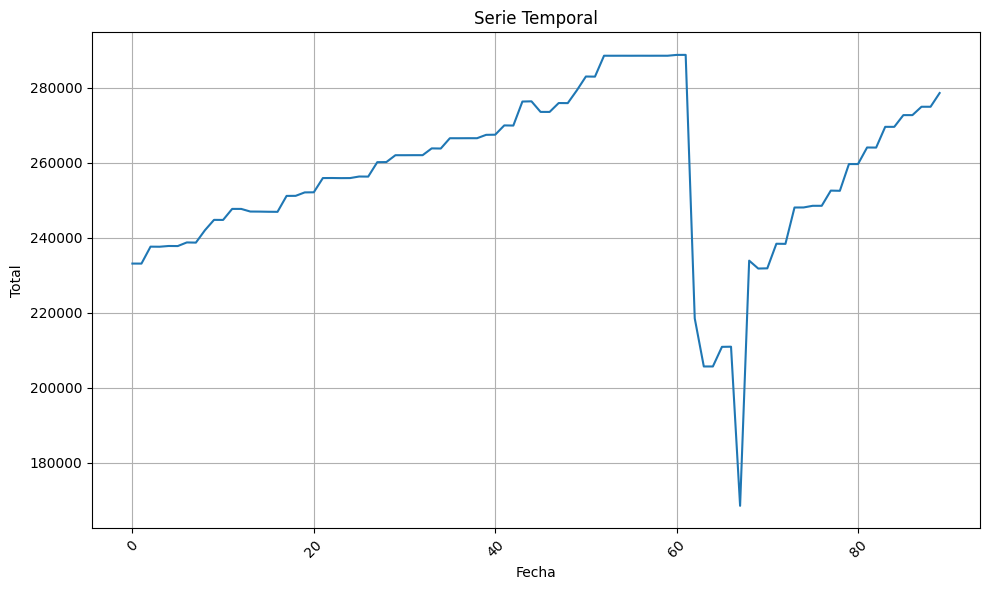

In [24]:
import matplotlib.pyplot as plt

# Leer el archivo CSV
df = pd.read_csv('../data/serie/serie_EU.csv')

# Convertir la columna 'year_month' a tipo datetime si es necesario
#df['year_month'] = pd.to_datetime(df['year_month'])

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))

# Trazar la serie temporal
plt.plot(df.index,df['total'])

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Total')
plt.title('Serie Temporal')

# Rotar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.grid(True)
plt.tight_layout()